General idea : Take the clean / ground truth images from dataset, add all types of noise to the image (using mathematical formula's, but varying parameters for each individual image).
Then, for each noised image assign a noise category. Use this (image, value) pair as (x_data, y_data) and train the model on a CNN.

In [1]:
# Note : The current code only takes into account each individual color channel and not a combination of all.

In [2]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as compare_ssim
import tensorflow as tf
import numpy as np
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
# As size of images are different, we will resize all images into common size.
image_width = 400
image_height = 300


def load_image(image_path):
    image = cv2.imread(image_path)
    if (image is None):
        print('failed to load image with path : ', image_path)
        
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    image = cv2.resize(image, (image_width, image_height))

    print('loaded image with path : ', image_path)
          
    return image

In [4]:
# Load images from data/folder (the clean / ground truth images)
gt_image_name = 'GT_SRGB_010.png'

ground_truth_images = []

for root, dirs, files in os.walk('../data/SIDD_Small_SRGB'):
    for dir in dirs:
        folder_path = os.path.join(root, dir)

        image_path = os.path.join(folder_path, gt_image_name)
        ground_truth_images.append(load_image(image_path))

loaded image with path :  ../data/SIDD_Small_SRGB\0001_001_S6_00100_00060_3200_L\GT_SRGB_010.png
loaded image with path :  ../data/SIDD_Small_SRGB\0002_001_S6_00100_00020_3200_N\GT_SRGB_010.png
loaded image with path :  ../data/SIDD_Small_SRGB\0003_001_S6_00100_00060_3200_H\GT_SRGB_010.png
loaded image with path :  ../data/SIDD_Small_SRGB\0004_001_S6_00100_00060_4400_L\GT_SRGB_010.png
loaded image with path :  ../data/SIDD_Small_SRGB\0005_001_S6_00100_00060_4400_N\GT_SRGB_010.png
loaded image with path :  ../data/SIDD_Small_SRGB\0006_001_S6_00100_00060_4400_H\GT_SRGB_010.png
loaded image with path :  ../data/SIDD_Small_SRGB\0007_001_S6_00100_00100_5500_L\GT_SRGB_010.png
loaded image with path :  ../data/SIDD_Small_SRGB\0008_001_S6_00100_00100_5500_N\GT_SRGB_010.png
loaded image with path :  ../data/SIDD_Small_SRGB\0010_001_S6_00800_00350_3200_N\GT_SRGB_010.png
loaded image with path :  ../data/SIDD_Small_SRGB\0011_001_S6_00800_00500_5500_L\GT_SRGB_010.png
loaded image with path :  ../d

number of images :  160
dimension of each image :  (300, 400, 3)


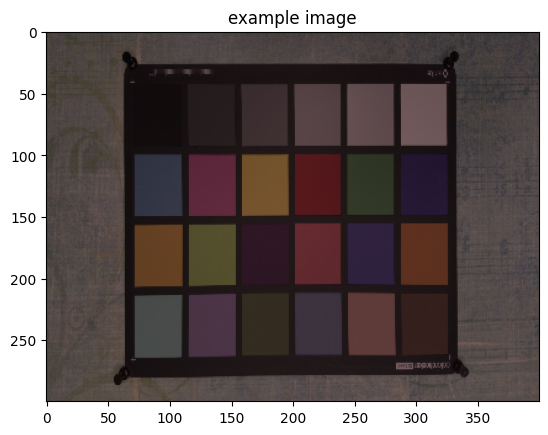

In [5]:
print('number of images : ', len(ground_truth_images))
print('dimension of each image : ', ground_truth_images[0].shape)
plt.title('example image')
plt.imshow(ground_truth_images[0])
plt.show()

In [6]:
# Generation of noise images from clean image.
from enum import Enum

class NoiseTypes(Enum):
    Gaussian = 0
    SaltAndPepper = 1
    Speckle = 2
    Quantization = 3
    Poisson = 4
    Uniform = 5
    White = 6
    Gamma = 7
    Count = 8

In [7]:
def show_image_pair(image1, title1, image2, title2):
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))

    axes[0].imshow(image1) 
    axes[0].set_title(title1)
    axes[0].axis('off')  

    axes[1].imshow(image2)  
    axes[1].set_title(title2)
    axes[1].axis('off')  


    axes[2].imshow(image2 - image1)
    axes[2].set_title('noise')
    axes[2].axis('off')
    
    plt.tight_layout()

    plt.show()
    

In [8]:
# Reference : https://medium.com/@ms_somanna/guide-to-adding-noise-to-your-data-using-python-and-numpy-c8be815df524
# Reference : https://theailearner.com/2019/05/07/add-different-noise-to-an-image/
# Reference : https://www.kaggle.com/code/chanduanilkumar/adding-and-removing-image-noise-in-python

# Range of std_deviation : 0->100
def add_gaussian_noise(channel, mean, std_deviation):
    noise = np.random.normal(mean, std_deviation, channel.shape)
    noisy_channel = channel + noise

    # Clip pixels values in range 0..255
    noisy_channel = np.clip(noisy_channel, 0, 255).astype(np.uint8)
    
    return noisy_channel

# Probability is per pixel probability of being affected by the noise.
# Range of 0..1
def add_salt_and_pepper_noise(channel, probability):
    noisy_channel = np.copy(channel)
    salt_coords = np.where(np.random.rand(*channel.shape) < probability / 2)
    pepper_coords = np.where(np.random.rand(*channel.shape) < probability / 2)
    noisy_channel[salt_coords] = 255
    noisy_channel[pepper_coords] = 0
    return noisy_channel

# Range of intensity -> 0..1
def add_speckle_noise(channel, intensity):
    noise = np.random.normal(0, intensity, channel.shape)
    noisy_channel = channel + (channel * noise)
    return noisy_channel

# Range of intensity -> 0..1
def add_quantization_noise(channel, intensity):
    intensity = np.clip(intensity, 0, 1)
    levels = 256
    
    quantization_error = np.random.uniform(-intensity / 2, intensity / 2, channel.shape)
    noisy_channel = (channel + quantization_error).astype(np.uint8)
    
    return noisy_channel

def add_poisson_noise(channel, intensity):
    noisy_channel = np.random.poisson(channel * intensity) / intensity
    return noisy_channel

def add_uniform_noise(channel, intensity):
    noise = np.random.uniform(-intensity, intensity, channel.shape)
    noisy_channel = channel + noise
    # Clip pixels values in range 0..255
    noisy_channel = np.clip(noisy_channel, 0, 255).astype(np.uint8)
    return noisy_channel

def add_white_noise(channel, intensity):
    noise = np.random.normal(0, intensity, channel.shape)
    noisy_channel = channel + noise
    return noisy_channel

def add_gamma_noise(channel, shape, scale):
    noise = np.random.gamma(shape, scale, channel.shape)
    noisy_channel = channel + noise

    # Clip pixels values in range 0..255
    noisy_channel = np.clip(noisy_channel, 0, 255).astype(np.uint8)
    
    return noisy_channel


In [9]:
gaussian_noise_images = []
salt_and_pepper_noise_images = []
speckle_noise_images = []
quantization_noise_images = []
poisson_noise_images = []
uniform_noise_images = []
white_noise_images = []
gamma_noise_images = []

# If add_to_array is false, then 
def add_noise_to_image(image, add_to_array = True):
    
    # Gaussian noise
    noisy_image = np.copy(image)

    for channel_index in range(0,image.shape[2]):
        noisy_image[:, :, channel_index] = add_gaussian_noise(noisy_image[:, :, channel_index], np.random.uniform(0, 20), np.random.uniform(0, 50))

    if add_to_array:
        gaussian_noise_images.append(noisy_image.copy())
    else:
        show_image_pair(image, 'clean', noisy_image, 'gaussian')

    # Salt and pepper noise
    noisy_image = np.copy(image)

    for channel_index in range(0, image.shape[2]):
        noisy_image[:, :, channel_index] = add_salt_and_pepper_noise(noisy_image[:, :, channel_index], np.random.uniform(0, 0.1))

    if add_to_array:
        salt_and_pepper_noise_images.append(noisy_image.copy())
    else:
        show_image_pair(image, 'clean', noisy_image, 'salt and pepper')

    # Speckle noise
    noisy_image = np.copy(image)

    for channel_index in range(0, image.shape[2]):
        noisy_image[:, :, channel_index] = add_speckle_noise(noisy_image[:, :, channel_index], np.random.uniform(0, 0.5))
        
    if add_to_array:
        speckle_noise_images.append(noisy_image.copy())
    else:
        show_image_pair(image, 'clean', noisy_image, 'speckle')

    # Quantization noise
    noisy_image = np.copy(image)

    for channel_index in range(0, image.shape[2]):
        noisy_image[:, :, channel_index] = add_quantization_noise(noisy_image[:, :, channel_index], np.random.uniform(0, 1) )
        
    if add_to_array:
        quantization_noise_images.append(noisy_image.copy())
    else:
        show_image_pair(image, 'clean', noisy_image, 'quantization')

    # Poisson noise  
    noisy_image = np.copy(image)

    for channel_index in range(0, image.shape[2]):
        noisy_image[:, :, channel_index] = add_poisson_noise(noisy_image[:, :, channel_index], np.random.uniform(0, 50))
    
    if add_to_array:
        poisson_noise_images.append(noisy_image.copy())
    else:
        show_image_pair(image, 'clean', noisy_image, 'poisson')

    # Uniform noise
    noisy_image = np.copy(image)
    
    for channel_index in range(0, image.shape[2]):
        noisy_image[:, :, channel_index] = add_uniform_noise(noisy_image[:, :, channel_index], np.random.uniform(0, 64))
        
    if add_to_array:
        uniform_noise_images.append(noisy_image.copy())
    else:
        show_image_pair(image, 'clean', noisy_image, 'uniform')

    # White noise
    noisy_image = np.copy(image)

    for channel_index in range(0, image.shape[2]):  
        noisy_image[:, :, channel_index] = add_white_noise(noisy_image[:, :, channel_index], np.random.uniform(0, 1))
        
    if add_to_array:
        white_noise_images.append(noisy_image.copy())
    else:
        show_image_pair(image, 'clean', noisy_image, 'white')

    # Gamma noise
    noisy_image = np.copy(image)

    for channel_index in range(0, image.shape[2]):    
        noisy_image[:, :, channel_index] = add_gamma_noise(noisy_image[:, :, channel_index], np.random.uniform(0, 2.0), np.random.uniform(0, 10.0))
        
    if add_to_array:
        gamma_noise_images.append(noisy_image.copy())
    else:
        show_image_pair(image, 'clean', noisy_image, 'gamma')
    

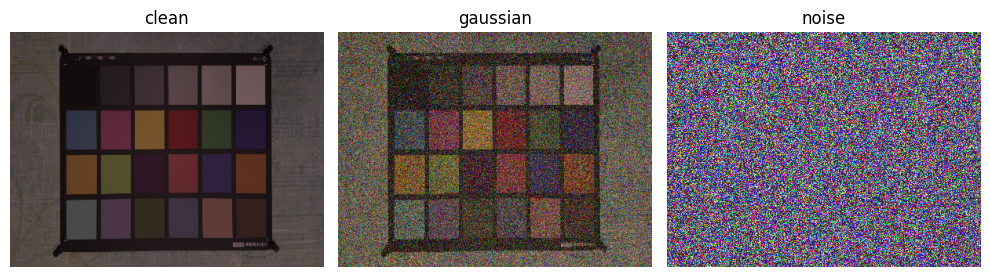

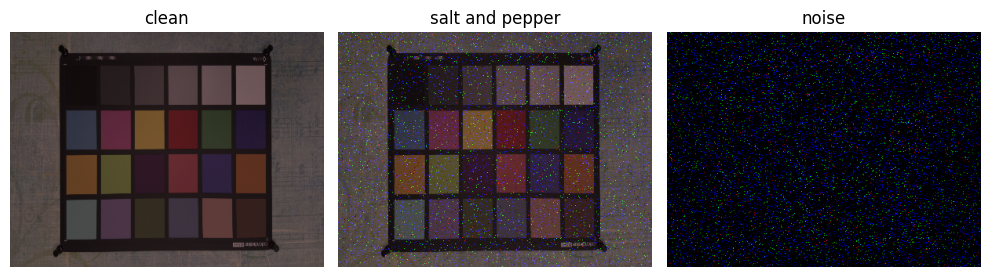

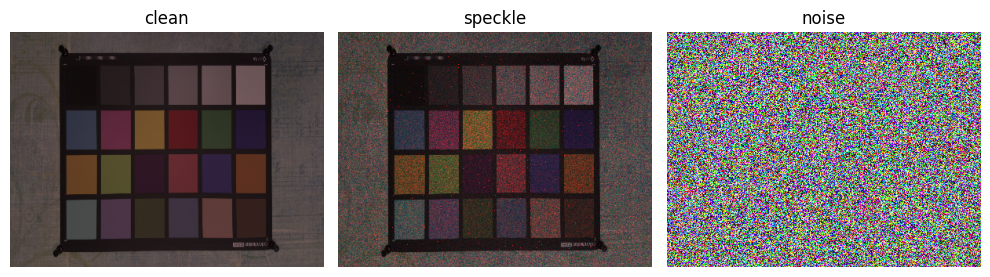

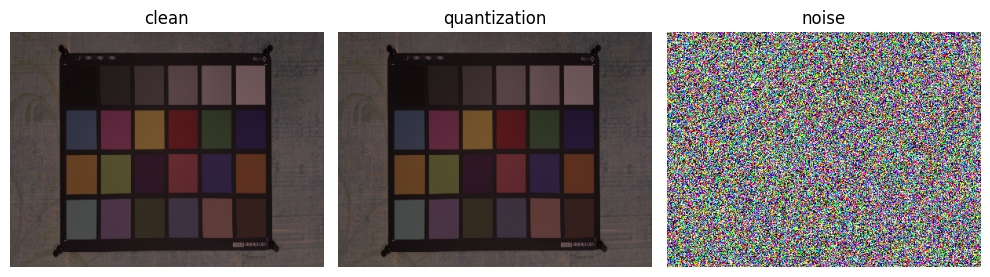

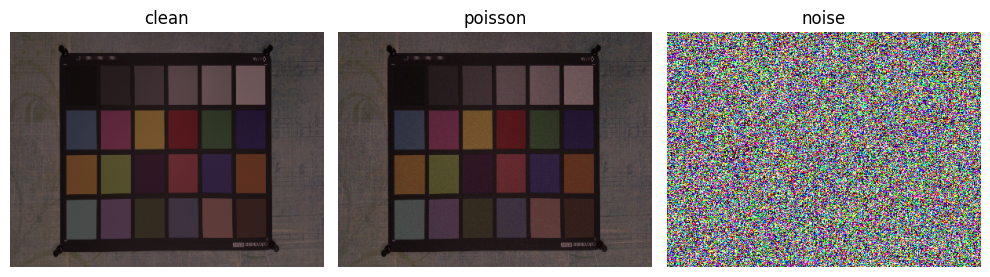

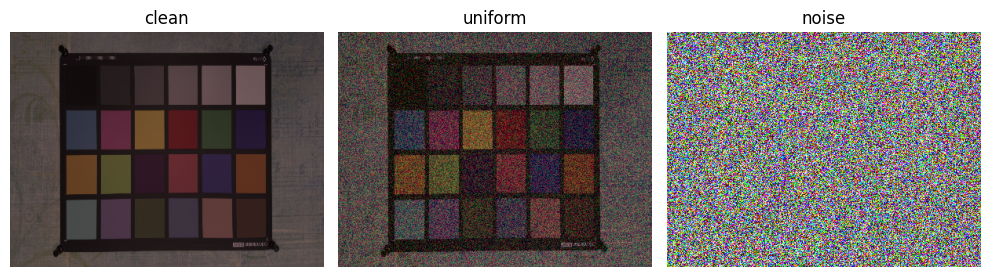

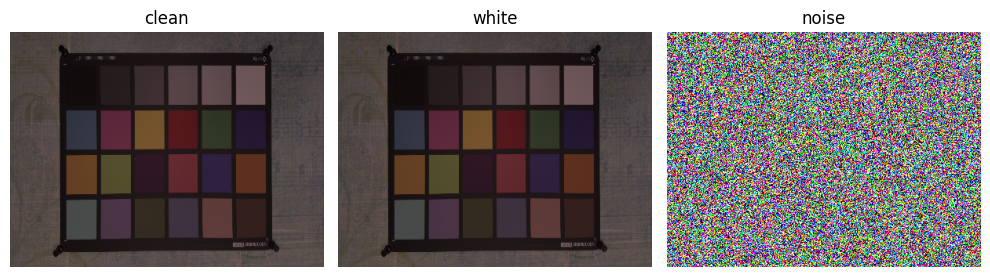

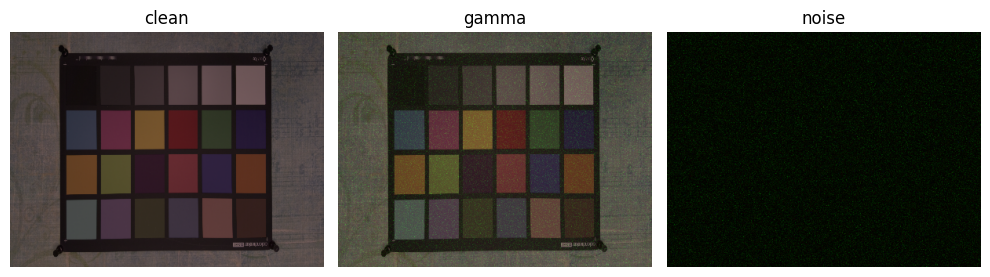

In [10]:
# Visualization (to check if the images are as expected / if range of intensity is sensible).
add_noise_to_image(ground_truth_images[0].copy(), False)

In [11]:
# Now, for all images generate noisy images.

for image in ground_truth_images:
    add_noise_to_image(image.copy())

In [12]:
# View len of all noisy image arrays
print(len(gaussian_noise_images))
print(len(salt_and_pepper_noise_images))
print(len(speckle_noise_images))
print(len(quantization_noise_images))
print(len(poisson_noise_images))
print(len(uniform_noise_images))
print(len(white_noise_images))
print(len(gamma_noise_images))


160
160
160
160
160
160
160
160


In [13]:
# Now, create the ylabel's.
gaussian_noise_label = [NoiseTypes.Gaussian.value] * len(gaussian_noise_images)
salt_and_pepper_noise_label = [NoiseTypes.SaltAndPepper.value] * len(salt_and_pepper_noise_images)
speckle_noise_label = [NoiseTypes.Speckle.value] * len(speckle_noise_images)
quantization_noise_label = [NoiseTypes.Quantization.value] * len(quantization_noise_images)
poisson_noise_label = [NoiseTypes.Poisson.value] * len(poisson_noise_images)
uniform_noise_label = [NoiseTypes.Uniform.value] * len(uniform_noise_images)
white_noise_label = [NoiseTypes.White.value] * len(white_noise_images)
gamma_noise_label = [NoiseTypes.Gamma.value] * len(gamma_noise_images)

In [14]:
# Now, the train test split can be done.
all_noise_images = np.concatenate([
    gaussian_noise_images,
    salt_and_pepper_noise_images,
    speckle_noise_images,
    quantization_noise_images,
    poisson_noise_images,
    uniform_noise_images,
    white_noise_images,
    gamma_noise_images
])

all_noise_labels = np.concatenate([
    gaussian_noise_label,
    salt_and_pepper_noise_label,
    speckle_noise_label,
    quantization_noise_label,
    poisson_noise_label,
    uniform_noise_label,
    white_noise_label,
    gamma_noise_label
])

print(len(all_noise_images), len(all_noise_labels))

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(all_noise_images, all_noise_labels, test_size=0.2, random_state=42)


1280 1280


In [15]:
# Split train data into train and validation 
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)


In [16]:
print('x_train : ', len(x_train))
print('y_train : ', len(y_train))

print('x_val : ', len(x_val))
print('y_val : ', len(y_val))

print('x_test : ', len(x_test))
print('y_test : ', len(y_test))

x_train :  819
y_train :  819
x_val :  205
y_val :  205
x_test :  256
y_test :  256


In [17]:
print('types of noise', NoiseTypes.Count.value)

types of noise 8


In [18]:
# Setup the model that will identify type of noise from image
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

x_train, x_test, x_val = x_train / 255.0, x_test / 255.0, x_val / 255.0  # Normalize pixel values to the range 0-1
y_train, y_test, y_val = to_categorical(y_train, NoiseTypes.Count.value), to_categorical(y_test, NoiseTypes.Count.value), to_categorical(y_val, NoiseTypes.Count.value)  # One-hot encode labels

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(NoiseTypes.Count.value, activation='softmax'))

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 398, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 149, 199, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 197, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 73, 98, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 96, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 436224)            0

In [20]:
# Compile the model
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=40, validation_data=(x_val, y_val))

Epoch 1/40
26/26 [==============================] - 80s 3s/step - loss: 2.0765 - accuracy: 0.1282 - val_loss: 2.0570 - val_accuracy: 0.1268
Epoch 2/40
26/26 [==============================] - 73s 3s/step - loss: 2.0213 - accuracy: 0.1416 - val_loss: 1.9857 - val_accuracy: 0.2732
Epoch 3/40
26/26 [==============================] - 73s 3s/step - loss: 1.9840 - accuracy: 0.1893 - val_loss: 2.0310 - val_accuracy: 0.2244
Epoch 4/40
26/26 [==============================] - 73s 3s/step - loss: 1.9716 - accuracy: 0.1819 - val_loss: 1.8979 - val_accuracy: 0.2049
Epoch 5/40
26/26 [==============================] - 73s 3s/step - loss: 1.9625 - accuracy: 0.2088 - val_loss: 1.8771 - val_accuracy: 0.2000
Epoch 6/40
26/26 [==============================] - 72s 3s/step - loss: 1.8432 - accuracy: 0.2369 - val_loss: 1.7764 - val_accuracy: 0.2000
Epoch 7/40
26/26 [==============================] - 72s 3s/step - loss: 1.8370 - accuracy: 0.2479 - val_loss: 1.9203 - val_accuracy: 0.2049
Epoch 8/40
26/26 [==

In [22]:
# Save the trained model.
model.save('../trained_models/simple_noise_identifier_v1.keras')

In [ ]:
# Trying to get the test error.
